In [2]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import numpy as np
import config
import geopandas as gpd
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap


In [3]:
tibet_bounds = (73.50, 26.00, 104.42, 39.99)    # tibet

### Tibet sentinel-1 image check

In [4]:
as_img_month = [122,122,122,122,117,117,113,122,123,122,122,122]
des_img_month = [104,101,107,96,110,107,116,115,118,113,113,111]
labels_month = ['January', 'February', 'March', 'April', 'May', 'June', \
                'July', 'August', 'September', 'October', 'November', 'December']

path_tibet_shp =  config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_s1as_fp_vec =  config.root_proj + '/data/tibet/s1_footprint/s1_as_footprint.gpkg'
path_s1des_fp_vec =  config.root_proj + '/data/tibet/s1_footprint/s1_des_footprint.gpkg'


In [5]:
geodf_as_fp = gpd.read_file(path_s1as_fp_vec)
geodf_des_fp = gpd.read_file(path_s1des_fp_vec)
print('ascending image:', len(geodf_as_fp))
print('descending image:', len(geodf_des_fp))
geodf_as_fp['geometry']


ascending image: 122
descending image: 115


0      MULTIPOLYGON (((93.06079 26.98771, 93.06861 26...
1      MULTIPOLYGON (((90.35619 27.82848, 90.33652 27...
2      MULTIPOLYGON (((90.00280 29.61206, 90.09641 29...
3      MULTIPOLYGON (((90.73880 31.29049, 90.79595 31...
4      MULTIPOLYGON (((92.22632 31.51248, 92.14578 31...
                             ...                        
117    MULTIPOLYGON (((73.87521 36.99005, 73.85136 37...
118    MULTIPOLYGON (((73.77179 37.55171, 73.75039 37...
119    MULTIPOLYGON (((73.15970 40.57632, 73.23959 40...
120    MULTIPOLYGON (((97.18923 34.17601, 97.17240 34...
121    MULTIPOLYGON (((86.14241 37.38582, 86.11559 37...
Name: geometry, Length: 122, dtype: geometry

### Footprint visualization

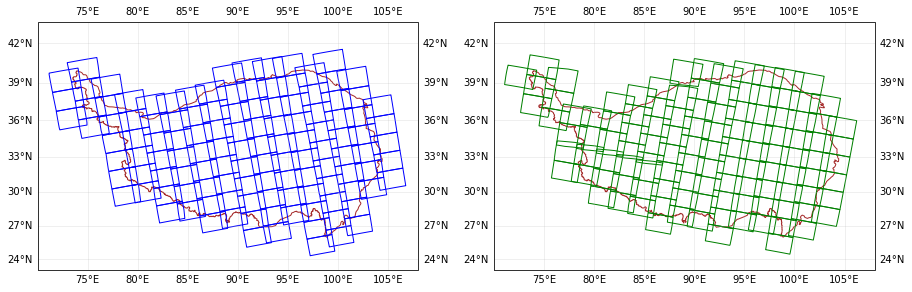

In [6]:
fig = plt.figure(figsize=(15, 6))
fea_tibet_shp = cfeature.ShapelyFeature(Reader(path_tibet_shp).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='Brown', linewidth=1, facecolor='none')
fea_as_fp = cfeature.ShapelyFeature(Reader(path_s1as_fp_vec).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='blue', linewidth=1, facecolor='none')
fea_des_fp = cfeature.ShapelyFeature(Reader(path_s1des_fp_vec).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='green', linewidth=1, facecolor='none')

## 1. ascending footprint visualization
ax_1 = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax_1.set_extent([70, 108, 23.0, 42.0])
ax_1.add_feature(fea_tibet_shp, zorder=0) ## add tibet boundary
ax_1.add_feature(fea_as_fp, zorder=0)     ## add ascending footprint
ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)

## 2. descending footprint visualization
ax_2 = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator(central_longitude=88.5))
ax_2.set_extent([70, 108, 23.0, 42.0])
ax_2.add_feature(fea_tibet_shp, zorder=0)  ## add tibet boundary
ax_2.add_feature(fea_des_fp, zorder=0)     ## add descending footprint
ax_2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)


### Monthly data numbers mapping

In [7]:
ids = ['01','02','03','04','05','06','07','08','09','10','11','12']
path_base_img = config.root_proj + '/data/tibet/dem/tibet_SRTMGL3_down.tif'
base_img, base_img_info = readTiff(path_base_img)
fp_as_months, fp_des_months = np.zeros_like(base_img), np.zeros_like(base_img)

for id in ids:
  ### ascending footprint
  path_s1as_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_2020' + id + '.kml'
  path_mask_as_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_mask_2020' + id + '.tif'
  fp_as_mask = vec2mask(path_vec=path_s1as_fp, \
                            path_raster=path_base_img, path_save = path_mask_as_fp)
  fp_as_months += fp_as_mask
  ### descending footprint
  path_s1des_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_2020' + id + '.kml'
  path_mask_des_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_mask_2020' + id + '.tif'
  fp_des_mask = vec2mask(path_vec=path_s1des_fp, \
                            path_raster=path_base_img, path_save=path_mask_des_fp)
  fp_des_months += fp_des_mask

fp_as_months_masked = np.ma.masked_equal(fp_as_months, 0)
fp_des_months_masked = np.ma.masked_equal(fp_des_months, 0)


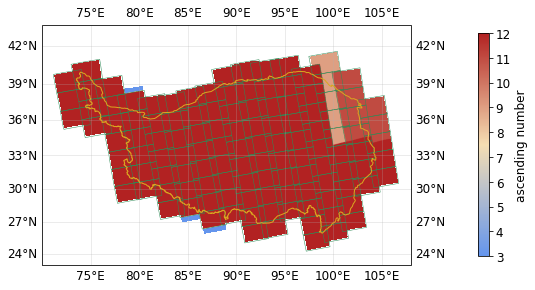

In [43]:
plt.rcParams.update({'font.size': 12})
cmap_num = LinearSegmentedColormap.from_list('linear color', ["CornflowerBlue", 'Wheat', "Firebrick"])
# cmap_num = LinearSegmentedColormap.from_list('linear color', ['Navy', "CornflowerBlue", 'Wheat', "Firebrick"])
fig = plt.figure(figsize=(8, 12))

### 1. ascending
ax_1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=89))
ax_1.set_extent([70, 108, 23.0, 42.0])
ax_as = ax_1.imshow(fp_as_months_masked, extent=base_img_info['geoextent'], 
                          vmin=3, vmax=12, cmap=cmap_num, transform=ccrs.PlateCarree(), zorder=0)  # cmap:PRGn
ax_1.add_feature(fea_as_fp, linewidth=0.5, edgecolor='SeaGreen', zorder=1)         ## add ascending footprint
ax_1.add_feature(fea_tibet_shp, edgecolor='Goldenrod', zorder=2)  ## add tibet boundary
ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
plt.colorbar(ax_as, fraction=0.025, pad=0.15, label='ascending number')  #
# plt.savefig(config.root_proj + '/figure/s1as_num_map.png', bbox_inches='tight')

# ### 2. descending
# ax_2 = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=89))
# ax_2.set_extent([70, 108, 23.0, 42.0])
# ax_des = ax_2.imshow(fp_des_months_masked, extent=base_img_info['geoextent'], 
#                           vmin=3, vmax=12, cmap=cmap_num, transform=ccrs.PlateCarree(), zorder=0)  # cmap:PRGn
# ax_2.add_feature(fea_des_fp, linewidth=0.5, edgecolor='SeaGreen', zorder=1)         ## add ascending footprint
# ax_2.add_feature(fea_tibet_shp, edgecolor='Goldenrod', zorder=2)  ## add tibet boundary
# ax_2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
# # plt.colorbar(ax_des, fraction=0.025, pad=0.15, label='ascending number')  #
# # plt.savefig(config.root_proj + '/figure/s1des_num_map.png', bbox_inches='tight')


### Monthly data collection statics


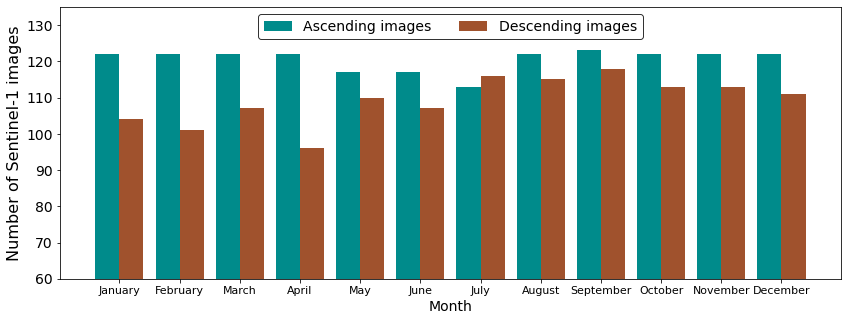

In [58]:

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(14,5))
width = 0.4
# ax.bar(np.arange(12), as_img_month, width=width, color='MediumSlateBlue', label = "Ascending images");
# ax.bar(np.arange(12)+width, des_img_month, width=width, color='NavajoWhite', label = "Descending images");
ax.bar(np.arange(12), as_img_month, width=width, color='DarkCyan', label = "Ascending images");
ax.bar(np.arange(12)+width, des_img_month, width=width, color='Sienna', label = "Descending images");

plt.xticks(np.arange(12) + width / 2, labels_month, fontsize=11, rotation=0);
plt.ylim([60, 135])
plt.legend(loc='upper center',ncol = 2, fontsize=14, frameon = True, edgecolor = 'black')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Sentinel-1 images', fontsize=16)
plt.savefig(config.root_proj + '/figure/s1_img_stat.png', bbox_inches='tight')


### tibet tile image check

In [43]:
idx = '012'
path_as = '/myDrive/tibet-water/tibet-202012/s1_ascend/tibet_s1as_202012_tile_' + idx + '.tif'
path_des = '/myDrive/tibet-water/tibet-202012/s1_descend/tibet_s1des_202012_tile_' + idx + '.tif'
tile_as, _ = readTiff(path_as)
tile_des, _ = readTiff(path_des)


In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imgShow(tile_as, color_bands=(0,1,0))
plt.subplot(1,2,2)
imgShow(tile_des, color_bands=(0,1,0))
